In [1]:
import os
import time
import math
import pickle
import numpy as np
import matplotlib.pyplot as plt
from nms import nms
from progress.bar import Bar
from PIL import Image, ImageDraw

# 1. Load data

In [2]:
def load_pgm_image(file_path):
    with open(file_path, 'rb') as f:
        header = f.readline().decode('ascii')
        assert header.strip() == 'P5', "PGM 파일이 아니거나 지원되지 않는 PGM 형식입니다."
        
        # 주석 건너뛰기
        while True:
            line = f.readline().decode('ascii')
            if line[0] != '#':
                break
        
        # 너비와 높이 읽기
        width, height = [int(i) for i in line.split()]
        max_val = int(f.readline().decode('ascii'))  # 최대 픽셀 값 (예: 255)
        
        # 이미지 데이터 읽기
        img = np.fromfile(f, dtype=np.uint8).reshape((height, width))
        
        return img

def load_all_pgms(folder_path):
    pgm_images = []
    
    # 폴더 내 모든 PGM 파일 불러오기
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.pgm'):
            file_path = os.path.join(folder_path, file_name)
            img = load_pgm_image(file_path)
            pgm_images.append(img)
    
    # 이미지 리스트를 NumPy 배열로 변환
    pgm_images_array = np.array(pgm_images)
    
    return pgm_images_array

In [3]:
train_face_folder_path = '/workspace/mlcnn/mitcbcl/train/face'
train_non_face_folder_path = '/workspace/mlcnn/mitcbcl/train/non-face'

train_face_images = load_all_pgms(train_face_folder_path)
train_non_face_images = load_all_pgms(train_non_face_folder_path)

train_X = np.concatenate([train_face_images, train_non_face_images], axis=0)
train_y = np.zeros(len(train_face_images) + len(train_non_face_images))
train_y[:len(train_face_images)] = 1

print(f"train X: {train_X.shape}")
print(f"train y: {train_y.shape}")

train X: (6977, 19, 19)
train y: (6977,)


In [4]:
test_face_folder_path = '/workspace/mlcnn/mitcbcl/test/face'
test_non_face_folder_path = '/workspace/mlcnn/mitcbcl/test/non-face'

test_face_images = load_all_pgms(test_face_folder_path)
test_non_face_images = load_all_pgms(test_non_face_folder_path)

test_X = np.concatenate([test_face_images, test_non_face_images], axis=0)
test_y = np.zeros(len(test_face_images) + len(test_non_face_images))
test_y[:len(test_face_images)] = 1

print(f"test X: {test_X.shape}")
print(f"test y: {test_y.shape}")

test X: (24045, 19, 19)
test y: (24045,)


# 2. Make Haar filter

In [5]:
class RectangleRegion:
    def __init__(self, x, y, width, height):
        self.x = x
        self.y = y
        self.width = width
        self.height = height

    def compute_region(self, ii, scale=1.0):
        x1 = int(self.x * scale)
        y1 = int(self.y * scale)
        x2 = x1 + int(self.width * scale) - 1
        y2 = y1 + int(self.height * scale) - 1

        # 사각형 영역 내 적분 이미지 값 계산
        S = int(ii[x2, y2])
        if x1 > 0: S -= int(ii[x1-1, y2])
        if y1 > 0: S -= int(ii[x2, y1-1])
        if x1 > 0 and y1 > 0: S += int(ii[x1 - 1, y1 - 1])
        return S  # 부호 없는 값으로 인한 계산 보정

class HaarFeature:
    def __init__(self, positive_regions, negative_regions):
        self.positive_regions = positive_regions  # 흰색 영역
        self.negative_regions = negative_regions  # 검은색 영역

    def compute_value(self, ii, scale=1.0):
        """
        적분 이미지에서 특징 값 계산
        """
        sum_pos = sum([rect.compute_region(ii, scale) for rect in self.positive_regions])
        sum_neg = sum([rect.compute_region(ii, scale) for rect in self.negative_regions])
        return sum_neg - sum_pos  # 특징 값은 검은색 영역에서 흰색 영역을 뺀 값

In [6]:
def build_filters(img_w, img_h, shift=1, scale_factor=1.25, min_w=4, min_h=4):
    """
    Haar 특징으로 필터 생성

    흰색 사각형에서 검은색 사각형 값을 뺌
    """
    filters = []  # [Tuple(positive regions, negative regions),...]

    # 특징 창 크기 조정
    for w_width in range(min_w, img_w + 1):
        for w_height in range(min_h, img_h + 1):

            # 이미지 전체 순회
            x = 0
            while x + w_width < img_w:
                y = 0
                while y + w_height < img_h:

                    # 가능한 Haar 영역 설정
                    immediate = RectangleRegion(x, y, w_width, w_height)  # |X|
                    right = RectangleRegion(x + w_width, y, w_width, w_height)  # | |X|
                    right_2 = RectangleRegion(x + w_width * 2, y, w_width, w_height)  # | | |X|
                    bottom = RectangleRegion(x, y + w_height, w_width, w_height)  # | |/|X|
                    bottom_right = RectangleRegion(x + w_width, y + w_height, w_width, w_height)  # | |/| |X|

                    # [Haar] 2개의 사각형 *********
                    # 수평 (흰색-검은색)
                    if x + w_width * 2 < img_w:
                        filters.append(HaarFeature([immediate], [right]))
                    # 수직 (흰색-검은색)
                    if y + w_height * 2 < img_h:
                        filters.append(HaarFeature([bottom], [immediate]))

                    # [Haar] 3개의 사각형 *********
                    # 수평 (흰색-검은색-흰색)
                    if x + w_width * 3 < img_w:
                        filters.append(HaarFeature([immediate, right_2], [right]))

                    # [Haar] 4개의 사각형 *********
                    if x + w_width * 2 < img_w and y + w_height * 2 < img_h:
                        filters.append(HaarFeature([immediate, bottom_right], [bottom, right]))

                    y += shift
                x += shift
    return filters

# 3. Get features

In [7]:
def apply_filters(X_ii, filters):
    """
    학습 데이터(적분 이미지)에 필터 적용
    """

    X = np.zeros((len(filters), len(X_ii)), dtype=np.int32)

    bar = Bar('필터 처리 중', max=len(filters), suffix='%(percent)d%% - %(elapsed_td)s - %(eta_td)s')
    for j, feature in bar.iter(enumerate(filters)):
        # 필터 'j'의 값을 학습 이미지들에 대해 계산 (각 분류기의 입력으로 사용)
        X[j] = list(map(lambda ii: feature.compute_value(ii), X_ii))
    bar.finish()

    return X

In [8]:
def integral_image(img):
    """
    합산 영역 테이블의 최적화 버전
    ii(-1, y) = 0  # 좌측 경계 처리
    s(x, -1) = 0  # 상단 경계 처리
    s(x, y) = s(x, y-1) + i(x, y)  # 열 X의 y 레벨까지의 합
    ii(x, y) = ii(x-1, y) + s(x, y)  # (X-1, Y) 위치의 적분 이미지 + 열 X의 y 레벨까지의 합
    """
    h, w = img.shape

    s = np.zeros(img.shape, dtype=np.uint32)  # 각 열의 누적 합을 저장할 배열
    ii = np.zeros(img.shape, dtype=np.uint32)  # 적분 이미지 배열

    for x in range(0, w):
        for y in range(0, h):
            # 현재 픽셀을 포함한 y까지의 열 합 계산
            s[y][x] = s[y - 1][x] + img[y][x] if y - 1 >= 0 else img[y][x]
            # 적분 이미지 계산 (이전 열의 적분값과 현재 열의 누적 합을 더함)
            ii[y][x] = ii[y][x - 1] + s[y][x] if x - 1 >= 0 else s[y][x]
    
    return ii

# 4. Train

In [9]:
class WeakClassifier:

    def __init__(self, haar_feature=None, threshold=None, polarity=None):
        # 약한 분류기 초기화
        self.haar_feature = haar_feature
        self.threshold = threshold
        self.polarity = polarity

    def classify(self, ii, scale=1.0):
        """
        적분 이미지 'ii'와 스케일이 주어졌을 때 분류를 수행
        """
        # 주어진 적분 이미지에서 Haar feature 값 계산
        feature_value = self.haar_feature.compute_value(ii, scale)
        # polarity와 임계값을 사용하여 분류
        return 1 if self.polarity * feature_value < self.polarity * self.threshold * (scale**2) else 0

    def classify_f(self, feature_value):
        """
        주어진 feature 값 또는 배열을 사용하여 분류
        """
        # polarity와 feature 값 비교 후 분류
        a = self.polarity * feature_value
        b = self.polarity * self.threshold
        return np.less(a, b).astype(int)

    def train(self, X, y, weights, total_pos_weights=None, total_neg_weights=None):
        # 긍정/부정 가중치 합 계산 (주어지지 않은 경우)
        if not total_pos_weights:
            total_pos_weights = np.sum(weights[np.where(y == 1)])
        if not total_neg_weights:
            total_neg_weights = np.sum(weights[np.where(y == 0)])

        # feature 값 기준으로 정렬
        sorted_features = sorted(zip(weights, X, y), key=lambda a: a[1])

        pos_seen, neg_seen = 0, 0
        sum_pos_weights, sum_neg_weights = 0, 0
        min_error, best_feature, best_threshold, best_polarity = float('inf'), None, None, None

        for w, f, label in sorted_features:
            # 오차 계산: 긍정/부정 가중치 중 작은 값 선택
            error = min(
                sum_neg_weights + (total_pos_weights - sum_pos_weights),
                sum_pos_weights + (total_neg_weights - sum_neg_weights)
            )

            # 최소 오차인 경우 임계값과 polarity 업데이트
            if error < min_error:
                min_error = error
                self.threshold = f
                self.polarity = 1 if pos_seen > neg_seen else -1

            # 레이블에 따라 가중치와 카운트 업데이트
            if label == 1:
                pos_seen += 1
                sum_pos_weights += w
            else:
                neg_seen += 1
                sum_neg_weights += w

In [10]:
class AdaBoost:
    """
    분류 오류가 높은 샘플에 대해 더 높은 가중치를 부여함으로써 해당 샘플이 더 중요하게 다뤄지도록 만듭니다.
    """
    def __init__(self, n_estimators=10):
        # AdaBoost 초기화: n_estimators는 약한 분류기의 수
        self.n_estimators = n_estimators
        self.alphas = []  # 약한 분류기 가중치
        self.clfs = []  # 약한 분류기 리스트

    def train(self, X, y, features, X_ii):
        # 긍정, 부정 샘플 수 계산
        pos_num = np.sum(y)
        neg_num = len(y) - pos_num
        weights = np.zeros(len(y), dtype=np.float32)

        # 초기 가중치 설정
        for i in range(len(y)):
            if y[i] == 1:  # 긍정 샘플
                weights[i] = 1.0 / (pos_num * 2.0)
            else:  # 부정 샘플
                weights[i] = 1.0 / (neg_num * 2.0)

        print("Training...")
        start_time = time.time()

        # 각 약한 분류기를 학습
        for t in range(self.n_estimators):
            print(f"Training {t + 1} classifiers out of {self.n_estimators}")

            # 가중치 정규화
            w_sum = np.sum(weights)
            if w_sum == 0.0:
                print("[WARNING] EARLY STOP. WEIGHTS ARE ZERO.")
                break
            weights = weights / w_sum

            # 약한 분류기 학습
            print("Training weak classifiers...")
            weak_classifiers = self.train_estimators(X, y, weights, features)

            # 가장 낮은 오차를 가진 약한 분류기 선택
            print("Selecting best weak classifiers...")
            clf, error, incorrectness = self.select_best(weak_classifiers, X, y, weights)

            if error <= 0.5:
                # alpha와 beta 계산
                beta = error / (1.0 - error)
                alpha = math.log(1.0 / (beta + 1e-18))

                # 가중치 업데이트
                weights = np.multiply(weights, beta ** (1 - incorrectness))

                # 최종 분류기 및 가중치 저장
                self.alphas.append(alpha)
                self.clfs.append(clf)
            else:
                print(error)
                print("WHAT THE FUCK!????")

        print(f"<== Training completed. Num. classifiers: {self.n_estimators}")

    def train_estimators(self, X, y, weights, features):
        # 약한 분류기 학습
        weak_clfs = []
        total_pos_weights, total_neg_weights = 0, 0

        for w, label in zip(weights, y):
            if label == 1:
                total_pos_weights += w
            else:
                total_neg_weights += w

        for i in range(len(X)):
            # 각 feature에 대해 약한 분류기 학습
            clf = WeakClassifier(haar_feature=features[i])
            clf.train(X[i], y, weights, total_pos_weights, total_neg_weights)
            weak_clfs.append(clf)

        return weak_clfs

    def select_best(self, weak_clfs, X, y, weights):
        # 최적의 약한 분류기를 선택
        best_clf, min_error, best_accuracy = None, float('inf'), None

        for i, clf in enumerate(weak_clfs):
            # 오차 계산
            incorrectness = np.abs(clf.classify_f(X[i]) - y)
            error = float(np.sum(np.multiply(incorrectness, weights))) / len(incorrectness)

            # 최소 오차를 가진 분류기 선택
            if error < min_error:
                best_clf, min_error, best_accuracy = clf, error, incorrectness

        return best_clf, min_error, best_accuracy

    def classify(self, X, scale=1.0):
        # 최종 분류 수행: 여러 약한 분류기의 가중치를 반영한 결과 반환
        total = sum(list(map(lambda x: x[0] * x[1].classify(X, scale), zip(self.alphas, self.clfs))))
        return 1 if total >= 0.5 * sum(self.alphas) else 0

In [11]:
class ViolaJones:

    def __init__(self, layers, features_path=None):
        assert isinstance(layers, list)
        self.layers = layers  # 약한 분류기의 개수(T)를 포함한 리스트
        self.clfs = []
        self.base_width, self.base_height = 19, 19  # 학습 데이터셋 이미지의 기본 크기
        self.base_scale, self.shift = 1.25, 2
        self.features_path = features_path  # 특징 저장 경로

    def train(self, X, y):
        """
        N개의 Viola-Jones 분류기(AdaBoost)를 점점 복잡하게 학습시킴.
        첫 번째 분류기 이후에는, 각 분류기는 양성 예시와 이전 분류기의 
        오탐(false positive) 예시에 대해 학습함.
        """
        print("데이터 준비 중...")

        # 학습 데이터 준비
        pos_num = np.sum(y)  # 양성 예시 개수
        neg_num = len(y) - pos_num  # 음성 예시 개수
        img_h, img_w = X[0].shape  # 모든 학습 이미지는 동일한 크기를 가짐

        # 양성 및 음성 샘플 분리
        pos_indices = np.where(y == 1)[0]
        neg_indices = np.where(y == 0)[0]

        # 데이터 정보 출력
        print("입력 데이터 요약:")
        print("\t- 얼굴 개수: {:,} ({:.2f}%)".format(int(pos_num), 100.0 * pos_num / (pos_num + neg_num)))
        print("\t- 얼굴이 아닌 이미지 개수: {:,} ({:.2f}%)".format(int(neg_num), 100.0 * neg_num / (pos_num + neg_num)))
        print("\t- 전체 샘플 수: {:,}".format(int(pos_num + neg_num)))
        print("\t- 이미지 크기 (가로x세로): {}x{}".format(img_w, img_h))

        # 가중치 초기화 및 적분 이미지 생성
        print("적분 이미지 생성 중...")
        start_time = time.time()
        X_ii = np.array(list(map(lambda x: integral_image(x), X)), dtype=np.uint32)
        print("\t- 적분 이미지 개수: {:,}".format(len(X_ii)))

        # 필터 생성 및 적용
        print("필터 생성 중...")
        start_time = time.time()
        features = build_filters(img_w, img_h)  # 모든 이미지에 동일한 필터 사용
        print("\t- 생성된 필터 수: {:,}".format(len(features)))

        print("필터 적용 중...")
        start_time = time.time()
        X_f = self.__load_feature_dataset()  # 저장된 특징 데이터셋 불러오기 (존재하는 경우)
        if X_f is None:
            X_f = apply_filters(X_ii, features)

            if self.features_path:  # 특징 저장
                np.save(self.features_path + "xf" + ".npy", X_f)
                print("적용된 특징 파일 저장 완료!")
        print("\t- 적용된 특징 수: {:,}".format(len(X_f) * len(features)))

        # Cascade 방식의 Viola-Jones 분류기 학습 (AdaBoost)
        for i, t in enumerate(self.layers):
            print("[CascadeClassifier] {}층 중 {}번째 층 학습 중".format(len(self.layers), i+1))
            if len(neg_indices) == 0:
                print('조기 종료: 모든 샘플이 올바르게 분류되었습니다.')
                break

            # 샘플 인덱스를 섞음
            tr_idxs = np.concatenate([pos_indices, neg_indices])
            np.random.shuffle(tr_idxs)

            # Viola-Jones (AdaBoost) 학습
            clf = AdaBoost(n_estimators=t)
            clf.train(X_f[:, tr_idxs], y[tr_idxs], features, X_ii[tr_idxs])
            self.clfs.append(clf)

            # 얼굴이 아닌 이미지 중 얼굴로 분류된 false positive 탐지
            false_positives = []
            for neg_idx in neg_indices:
                if self.classify(X[neg_idx]) == 1:
                    false_positives.append(neg_idx)
            neg_indices = np.array(false_positives)

    def classify(self, image, scale=1.0):
        """
        얼굴이 아닌 것으로 판정되면 즉시 종료.
        얼굴이 아닐 경우 계속해서 검사 진행.
        """
        return self.classify_ii(integral_image(image), scale)

    def classify_ii(self, ii, scale=1.0):
        """
        얼굴이 아닌 것으로 판정되면 즉시 종료.
        얼굴이 아닐 경우 계속해서 검사 진행.
        """
        for clf in self.clfs:  # ViolaJones 분류기
            if clf.classify(ii, scale) == 0:
                return 0
        return 1

    def find_faces(self, pil_image):
        """
        PIL 이미지에서 얼굴을 탐지
        """
        w, h, s = (self.base_width, self.base_height, self.base_scale)
        regions = []

        # 이미지 전처리 (흑백 변환)
        pil_image = pil_image.convert('L')
        image = np.array(pil_image)
        img_h, img_w = image.shape

        # 적분 이미지 계산
        ii = integral_image(image)

        # 슬라이딩 윈도우 탐색
        # 탐색 영역의 크기가 이미지보다 작아야 함
        counter = 0
        while int(w * s) < img_w and int(h * s) < img_h:

            # 탐색 영역이 이미지 범위 안에 있어야 함
            for y1 in np.arange(0, int(img_h) - int(h * s), self.shift):
                for x1 in np.arange(0, int(img_w) - int(w * s), self.shift):
                    y1, x1 = int(y1), int(x1)
                    y2, x2 = y1 + int(h * s), x1 + int(w * s)
                    cropped_img = ii[y1:y2, x1:x2]

                    if self.classify_ii(cropped_img, scale=s):  # CascadeClassifier를 통한 분류
                        regions.append((x1, y1, x2, y2))

                    counter += 1
                    print("분석된 크롭 수: {}".format(counter))

            # 탐색 윈도우 크기 확대
            w *= s
            h *= s

        return regions

    def save(self, filename):
        with open(filename + ".pkl", 'wb') as f:
            pickle.dump(self, f)

    @staticmethod
    def load(filename):
        with open(filename, 'rb') as f:
            return pickle.load(f)

    def __load_feature_dataset(self):
        X_f = None
        # 사전 계산된 특징 데이터셋 로드
        try:
            if self.features_path:
                X_f = np.load(self.features_path + "xf" + ".npy")
                print("사전 계산된 데이터셋 로드 완료!")
        except FileNotFoundError:
            pass
        return X_f

In [13]:
print("\nViola-Jones 훈련 중...")
features_path = '/workspace/HDD/save/'
clf = ViolaJones(layers=[1, 1, 1, 1], features_path=features_path)
clf.train(train_X, train_y)  # X_f (선택 사항, 훈련 속도 향상용)
print("훈련 완료!")

# 가중치 저장
print("\n가중치 저장 중...")
clf.save(features_path + 'cvj_weights_' + str(int(time.time())))
print("가중치 저장 완료!")


Viola-Jones 훈련 중...
데이터 준비 중...
입력 데이터 요약:
	- 얼굴 개수: 2,429 (34.81%)
	- 얼굴이 아닌 이미지 개수: 4,548 (65.19%)
	- 전체 샘플 수: 6,977
	- 이미지 크기 (가로x세로): 19x19
적분 이미지 생성 중...
	- 적분 이미지 개수: 6,977
필터 생성 중...
	- 생성된 필터 수: 11,376
필터 적용 중...
적용된 특징 파일 저장 완료!
	- 적용된 특징 수: 129,413,376
[CascadeClassifier] 4층 중 1번째 층 학습 중
Training...
Training 1 classifiers out of 1
Training weak classifiers...
Selecting best weak classifiers...
<== Training completed. Num. classifiers: 1
[CascadeClassifier] 4층 중 2번째 층 학습 중
Training...
Training 1 classifiers out of 1
Training weak classifiers...
Selecting best weak classifiers...
<== Training completed. Num. classifiers: 1
[CascadeClassifier] 4층 중 3번째 층 학습 중
Training...
Training 1 classifiers out of 1
Training weak classifiers...
Selecting best weak classifiers...
<== Training completed. Num. classifiers: 1
[CascadeClassifier] 4층 중 4번째 층 학습 중
Training...
Training 1 classifiers out of 1
Training weak classifiers...
Selecting best weak classifiers...
<== Training completed. Num.

# 5. Eval

In [14]:
def evaluate(clf, X, y, show_samples=False):
    metrics = {}
    true_positive, true_negative = 0, 0  # 올바른 예측 수
    false_positive, false_negative = 0, 0  # 잘못된 예측 수

    for i in range(len(y)):
        prediction = clf.classify(X[i])
        if prediction == y[i]:  # 올바른 예측
            if prediction == 1:  # 얼굴
                true_positive += 1
            else:  # 비얼굴
                true_negative += 1
        else:  # 잘못된 예측
            # if show_samples: show_sample(X[i], y[i], prediction)

            if prediction == 1:  # 얼굴
                false_positive += 1
            else:  # 비얼굴
                false_negative += 1

    # 지표 계산
    metrics['true_positive'] = true_positive
    metrics['true_negative'] = true_negative
    metrics['false_positive'] = false_positive
    metrics['false_negative'] = false_negative

    metrics['accuracy'] = (true_positive + true_negative) / (true_positive + false_negative + true_negative + false_positive)  # 정확도
    metrics['precision'] = true_positive / (true_positive + false_positive)  # 정밀도
    metrics['recall'] = true_positive / (true_positive + false_negative)  # 재현율 또는 민감도
    metrics['specifity'] = true_negative / (true_negative + false_positive)  # 특이도
    metrics['f1'] = (2.0 * metrics['precision'] * metrics['recall']) / (metrics['precision'] + metrics['recall'])  # F1 점수

    return metrics

In [15]:
# Evaluate
name = "test"
print("\n평가 중...")
metrics = evaluate(clf, test_X, test_y, show_samples=False)

print("지표: [{}]".format(name))
counter = 0
for k, v in metrics.items():
    counter += 1
    if counter <= 4:
        print("\t- {}: {:,}".format(k, v))
    else:
        print("\t- {}: {:.3f}".format(k, v))


평가 중...
지표: [test]
	- true_positive: 4
	- true_negative: 23,454
	- false_positive: 119
	- false_negative: 468
	- accuracy: 0.976
	- precision: 0.033
	- recall: 0.008
	- specifity: 0.995
	- f1: 0.013


In [16]:
def draw_bounding_boxes(pil_image, regions, color="green", thickness=3):
    # 이미지를 준비합니다.
    source_img = pil_image.convert("RGBA")
    draw = ImageDraw.Draw(source_img)
    for rect in regions:
        draw.rectangle(tuple(rect), outline=color, width=thickness)
    return source_img


def find_faces(weight_path, face_path):
    # 분류기 가중치를 로드합니다.
    clf = ViolaJones.load(weight_path)

    # 얼굴의 영역을 찾습니다.
    numpy_img = load_pgm_image(face_path)
    pil_img = Image.fromarray(numpy_img)
    regions = clf.find_faces(pil_img)

    # 바운딩 박스를 그립니다.
    # TODO: 비최대 억제(Non-maximum suppression) 검토 (자체 구현 수정)
    scores = [1.0] * len(regions)  #np.ones(len(regions))
    indicies = nms.boxes(regions, scores)
    regions = np.array(regions)
    print(f"scores: {scores}")
    print(f"regions: {regions}")

    drawn_img = draw_bounding_boxes(pil_img, list(regions[indicies]), thickness=1)
    # drawn_img = draw_bounding_boxes(pil_img, list(regions), thickness=1)

    # 이미지를 표시합니다.
    plt.imshow(drawn_img)
    plt.show()

scores: []
regions: []


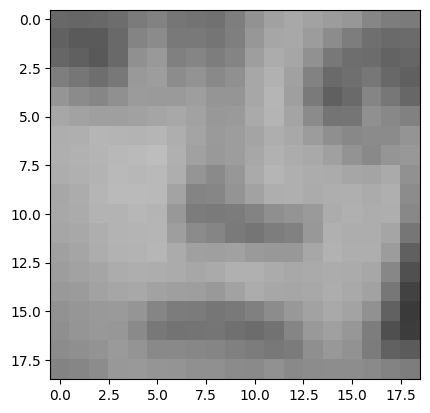

In [18]:
weight_path = "/workspace/HDD/savecvj_weights_1729217241.pkl"
face_path = "/workspace/mlcnn/mitcbcl/test/face/cmu_0000.pgm"

find_faces(weight_path, face_path)